In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils

In [2]:
import string
alphabet = list(string.ascii_lowercase)
          

## Data

Data for this is from https://gmd.copernicus.org/articles/11/1133/2018/ CDRMIP data, where pi-CO2pulse is the 100GtC pulse and piControl is the control

In [3]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['__xarray_dataarray_variable__']
G_mean_ds = xr.open_dataset('Outputs/G_mean_ds.nc4')['__xarray_dataarray_variable__']
G_cdr_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']
G_cdr_mean_ds = xr.open_dataset('Outputs/G_cdr_mean_ds.nc4')['__xarray_dataarray_variable__']

In [4]:
ds_out = utils.ds_out

In [5]:
A = utils.find_area(ds_out)

## Global Mean plots

In [6]:
model_color = utils.model_color

In [9]:

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


In [ ]:
fig, axes = plt.subplots(2,4,figsize = [30,10], sharey = True, sharex = True)
alpha_labels = iter(alphabet)

plt.suptitle('Annual Mean Green\'s Function', fontsize = 16)
for ax, m in zip(axes.ravel(), G_ds.model.values):
    G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(ax = ax, color = model_color[m])
    (-G_cdr_ds).weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(ax = ax, color = model_color[m], linestyle = '--', linewidth = 2)
    ax.set_xlim(G_ds.year.min(), G_ds.year[150].values)
    ax.set_title(m, fontsize = 14)
    
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    label = next(alpha_labels)
    ax.text(x = .06, y =.94, s = label, transform=ax.transAxes, fontweight="bold")
  
    
axes[0,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
axes[1,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
for idx in [0,1,2,3]:
    axes[1,idx].set_xlabel('Years', fontsize = 14)


####### legend ##########
 
cdr = Line2D([0], [0], linestyle = '--', label='esm-pi-CDRpulse', color='black')
co2 = Line2D([0], [0], label='esm-pi-CO2pulse', color='black')
handles = [cdr, co2]
plt.legend(handles=handles)

plt.tight_layout()
plt.savefig('figures/paper/GF_mean_all_models.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
for m in G_ds.model.values:
    plt.plot(G_ds.weighted(A).mean(dim = ['year','lat','lon']).sel(model = m), -
             G_cdr_ds.weighted(A).mean(dim = ['year','lat','lon']).sel(model = m), 
             'o', color = utils.model_color[m], label = m)
plt.plot(np.arange(0,0.006,0.0001),np.arange(0,0.006,0.0001))
plt.legend(bbox_to_anchor=(2.0,0.5))
plt.xlim(0,0.005)
plt.xlabel('Pulse', fontsize = 14)
plt.ylim(0,0.005)
plt.ylabel('CDR', fontsize = 14)
plt.title('Mean Green\'s Function', fontsize = 14)
plt.savefig('figures/GF_dev/comparison_mean.png', bbox_inches = 'tight', dpi = 300)

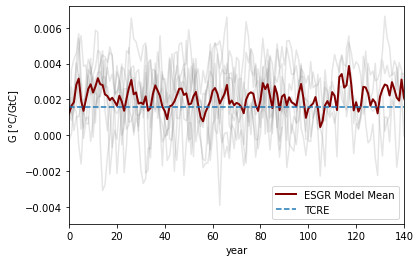

In [13]:
for m in G_ds.model:
    G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(alpha = .2, color = 'grey')
plt.title('Annual Mean', fontsize = 16)
plt.xlim(G_ds.year.min(), G_ds.year[140].values)

G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = 'model').plot(label = 'ESGR Model Mean', color = 'maroon', linewidth = 2)
plt.axhline(0.00155475, linestyle = '--', label = 'TCRE')
plt.ylabel('G [$\degree$C/GtC]')
plt.legend()
plt.savefig('figures/GF_dev/all_models_monthly.png', bbox_inches = 'tight', dpi = 350)


## Spatial Plots

Text(0.5, 1.0, '')

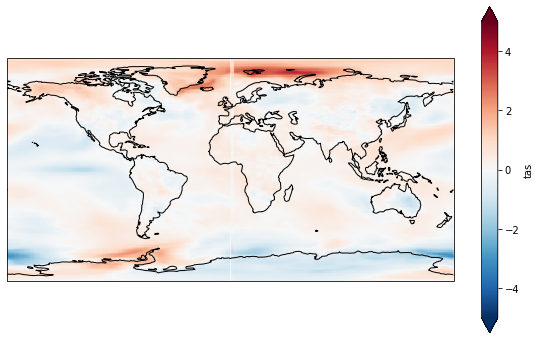

In [14]:
fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize = [10,6])
(G_mean_ds.isel(year = 50)*100).plot(ax = ax, transform = ccrs.PlateCarree(), vmin = -5, vmax = 5, cmap = 'RdBu_r', extend = 'both')

ax.coastlines()
#ax.set_title('30 years')
plt.title('')


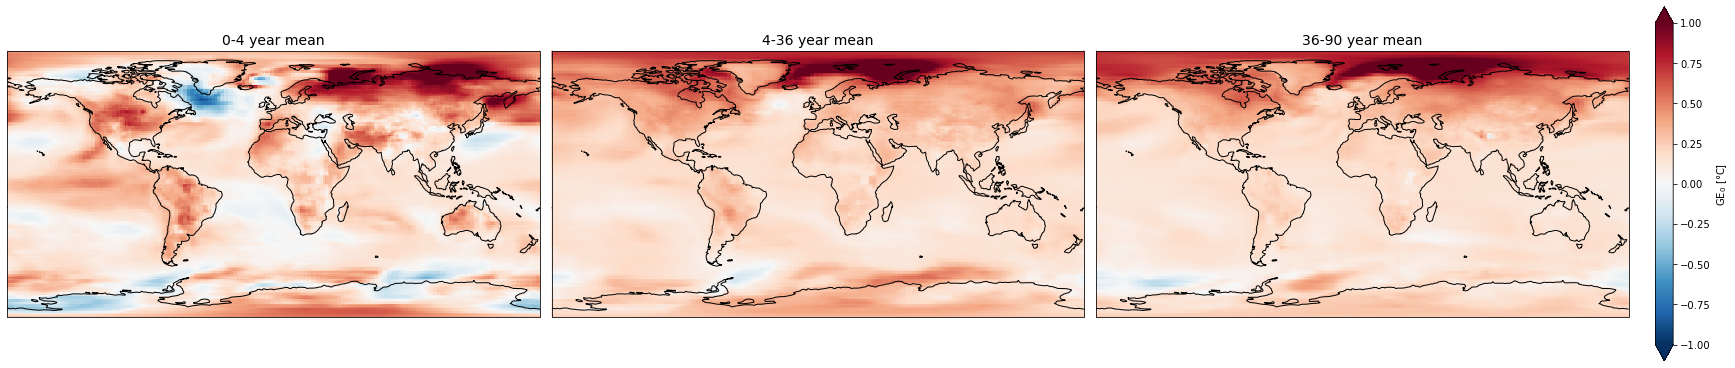

In [46]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = [24,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout=True)
(G_ds.mean(dim = ['model'])*100).isel(year = slice(0,4)).mean(dim = 'year').plot(ax = ax0, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r', add_colorbar = False)
ax0.set_title('0-4 year mean', fontsize = 14)
ax0.coastlines()
(G_ds.mean(dim = ['model'])*100).isel(year = slice(4,36)).mean(dim = 'year').plot(ax = ax1, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r', add_colorbar = False)
ax1.set_title('4-36 year mean', fontsize = 14)
ax1.coastlines()

(G_ds.mean(dim = ['model'])*100).isel(year = slice(36,90)).mean(dim = 'year').plot(ax = ax2, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax2.set_title('36-90 year mean', fontsize = 14)
ax2.coastlines()


plt.savefig('figures/paper/GF_time_varying.png', bbox_inches = 'tight', dpi = 350)

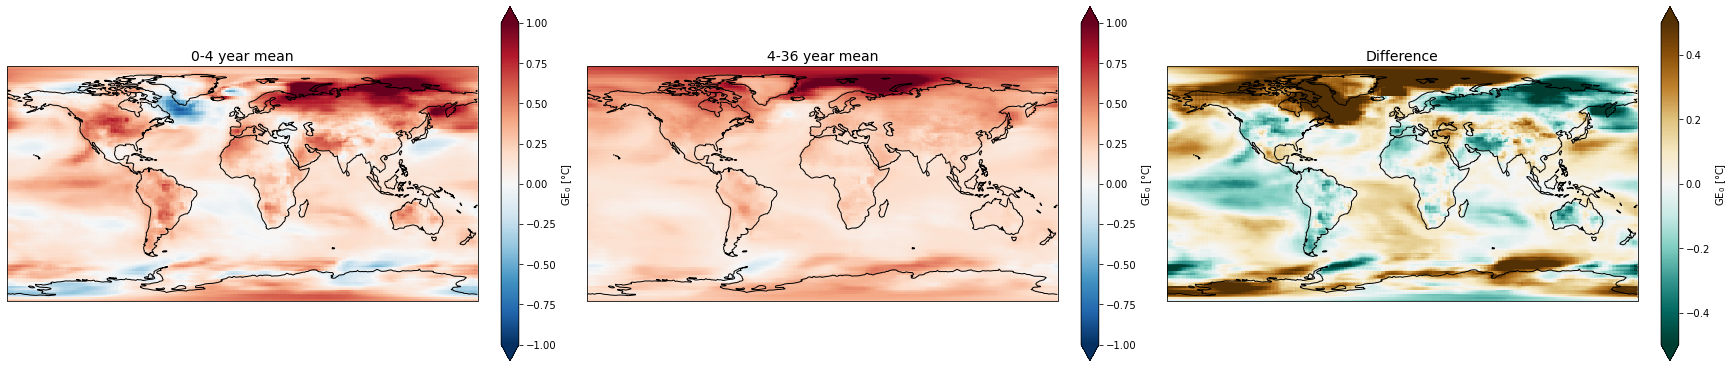

In [47]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = [24,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout=True)
(G_ds.mean(dim = ['model'])*100).isel(year = slice(0,4)).mean(dim = 'year').plot(ax = ax0, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax0.set_title('0-4 year mean', fontsize = 14)
ax0.coastlines()
(G_ds.mean(dim = ['model'])*100).isel(year = slice(4,36)).mean(dim = 'year').plot(ax = ax1, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax1.set_title('4-36 year mean', fontsize = 14)
ax1.coastlines()

((G_ds.mean(dim = ['model'])*100).isel(year = slice(4,36)).mean(dim = 'year') - 
 (G_ds.mean(dim = ['model'])*100).isel(year = slice(0,4)).mean(dim = 'year')).plot(ax = ax2, vmax = 0.5, vmin = -0.5, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'BrBG_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax2.set_title('Difference', fontsize = 14)
ax2.coastlines()
plt.savefig('figures/paper/GF_time_varying.png', bbox_inches = 'tight', dpi = 350)

In [19]:
from scipy.stats import norm
mean, var, skew, kurt = norm.stats(moments='mvsk')

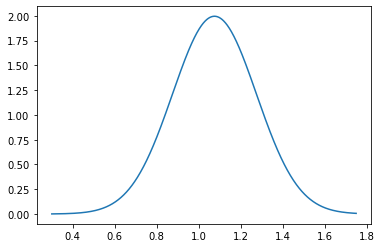

In [56]:

x = np.linspace(0.3, 1.75, 1000)
plt.plot(x, norm.pdf(x, 1.075, 0.2))
plt.show()

In [63]:
norm.pdf(x)

array([[0.39894169, 0.39894225, 0.39893964, 0.39893942, 0.39894054,
        0.39894178, 0.39893999, 0.39893901, 0.39893551, 0.39894101,
        0.39894005, 0.39893946, 0.39894126, 0.39894098, 0.39894067,
        0.39894034, 0.39894226, 0.39894143, 0.39894228, 0.39894182,
        0.39894224, 0.39894196, 0.39894226, 0.39894219]])

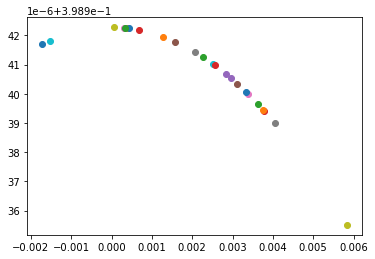

In [66]:

x = G_ds.weighted(A).mean(dim = ['lat','lon']).isel(year = slice(9,12)).values.reshape(1,24)
plt.plot(x, norm.pdf(x), 'o');


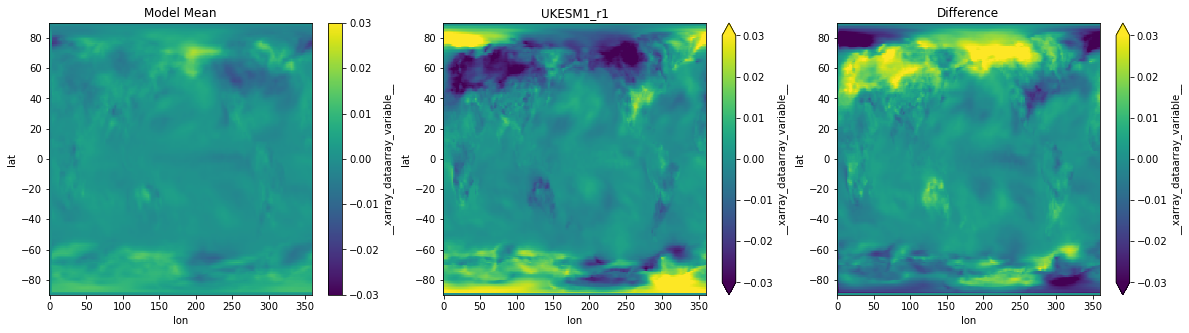

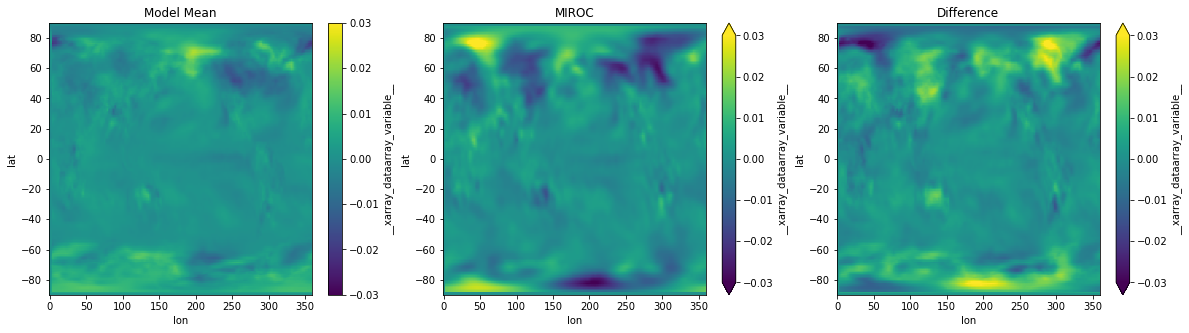

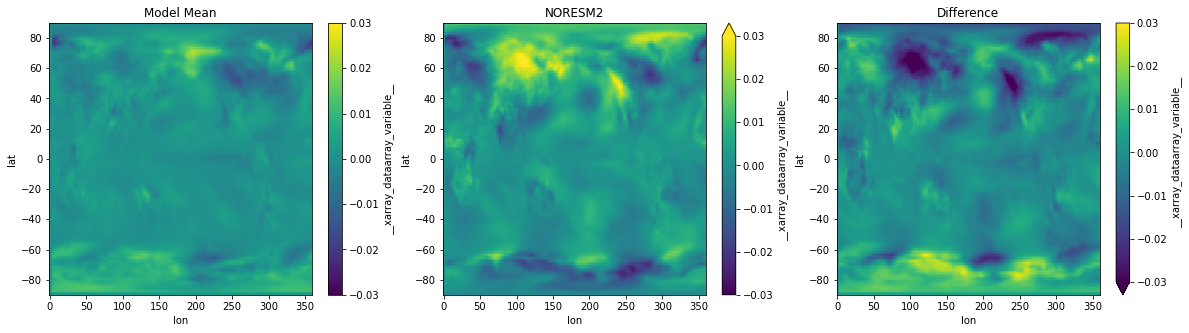

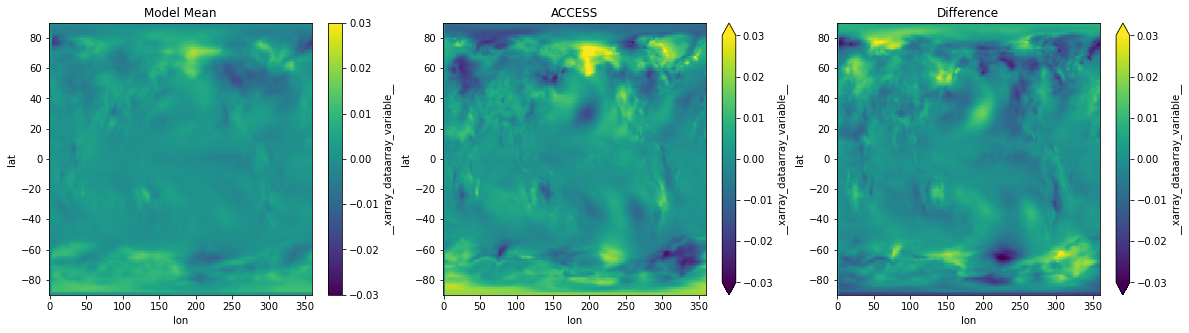

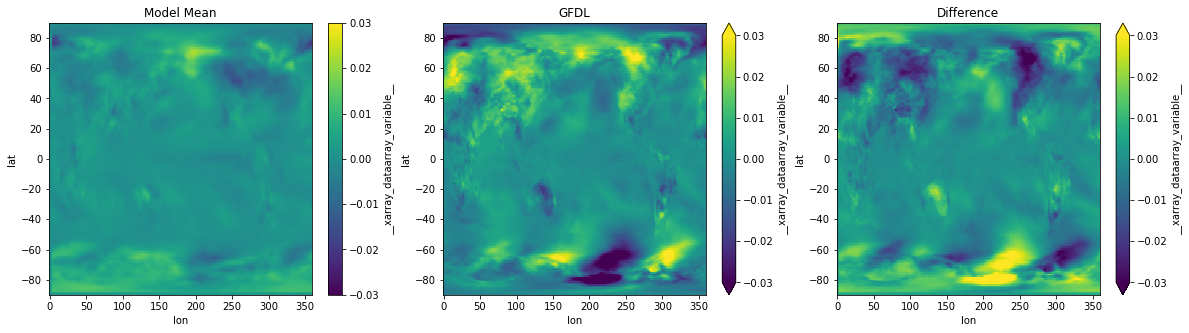

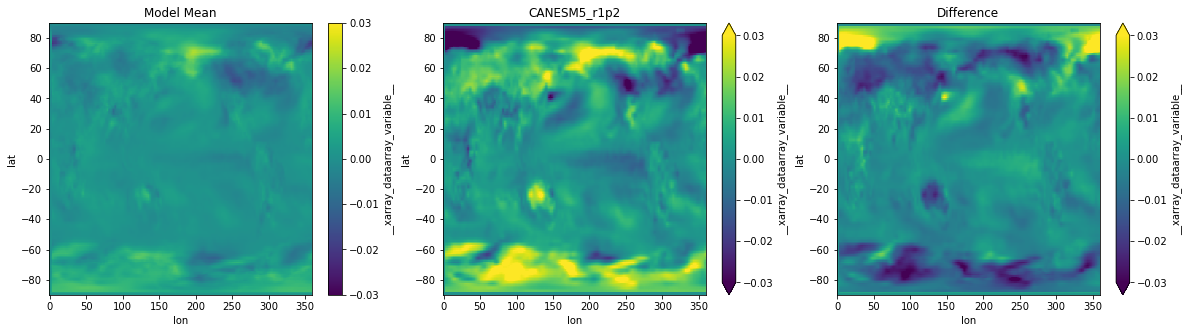

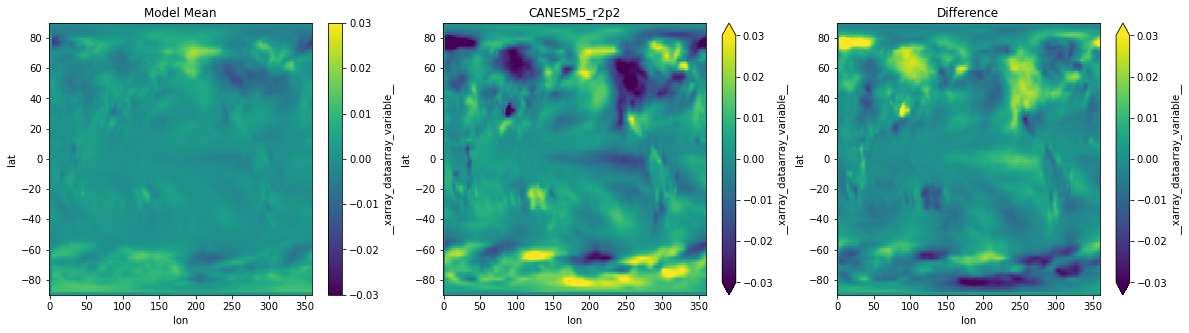

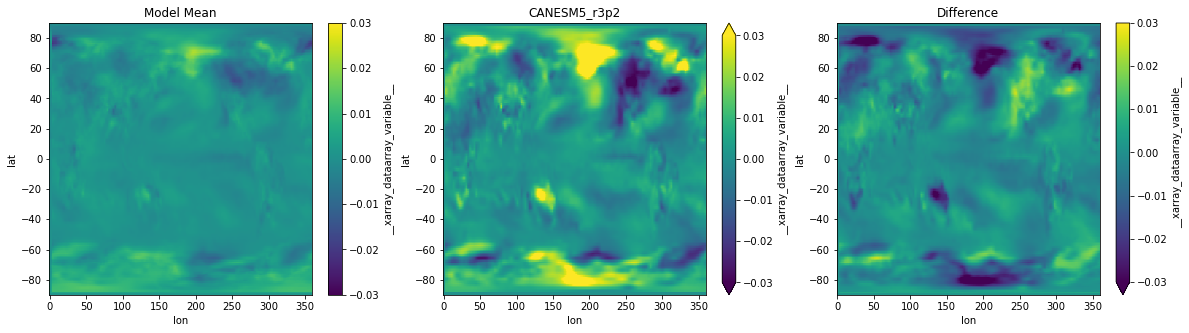

In [18]:
for m in G_ds.model:
    fig, [ax0, ax1, ax2] = plt.subplots(1,3, figsize = [20,5])
    G_ds.mean(dim = ['model']).isel(year = 0).plot(ax = ax0, vmax = 0.03, vmin = -0.03)
    ax0.set_title('Model Mean')
    (G_ds.mean(dim = ['model']).isel(year = 0) - G_ds.sel(model = m).isel(year = 0)).plot(ax = ax2, vmax = 0.03, vmin = -0.03)
    ax2.set_title('Difference')
    G_ds.sel(model = m).isel(year = 0).plot(ax = ax1, vmax = 0.03, vmin = -0.03)
    ax1.set_title(f'{m.values}')
    

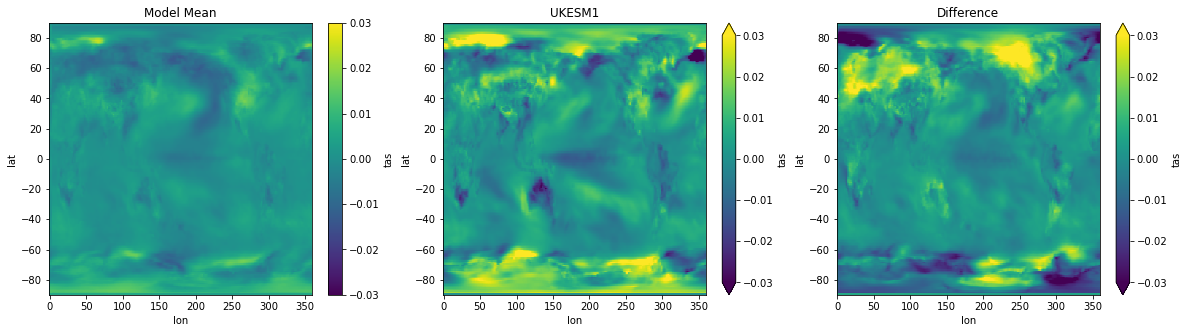

In [10]:
for m in G_ds.model[:1]:
    fig, [ax0, ax1, ax2] = plt.subplots(1,3, figsize = [20,5])
    G_ds.mean(dim = ['model']).isel(year = 30).plot(ax = ax0, vmax = 0.03, vmin = -0.03)
    ax0.set_title('Model Mean')
    (G_ds.mean(dim = ['model']).isel(year = 30) - G_ds.sel(model = m).isel(year = 0)).plot(ax = ax2, vmax = 0.03, vmin = -0.03)
    ax2.set_title('Difference')
    G_ds.sel(model = m).isel(year = 30).plot(ax = ax1, vmax = 0.03, vmin = -0.03)
    ax1.set_title(f'{m.values}')
    

## Test CO2 trajectories

In [14]:
import scipy.signal as signal

In [64]:
plateau_drop_emis = np.append(np.linspace(7,10, 20),np.linspace(10,0,30))

In [65]:
increase_emis = np.linspace(7,22, 50)

In [66]:
plateau_out = signal.convolve(G_mean_ds.to_numpy(), plateau_drop_emis[..., None, None], 'full')
increase_out = signal.convolve(G_mean_ds.to_numpy(), increase_emis[..., None, None], 'full')

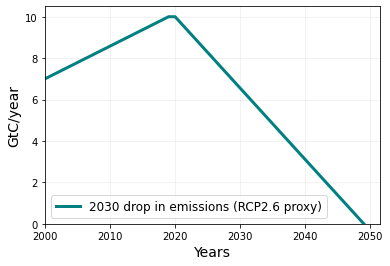

In [69]:
fig, ax =plt.subplots()
#plt.plot(increase_emis, label = 'Continuous increase (RCP8.5 proxy)', color = 'teal', linewidth = 3)
plt.plot(np.arange(2000,2050), plateau_drop_emis, label = '2030 drop in emissions (RCP2.6 proxy)', color = 'teal', linewidth = 3)
plt.legend(fontsize = 12)
plt.grid(alpha = 0.2)
plt.xlim(2000,None)
plt.ylim(0,None)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('GtC/year', fontsize = 14)
plt.savefig('figures/emis_timeseries.pdf', bbox_inches = 'tight', dpi = 350)

In [40]:
def np_to_xr(C, G, E):
    E_len = len(E)
    G_len = len(G.year)
    C = xr.DataArray(
    data = C,
    dims = ['year','lat','lon'],
    coords = dict(
        year = (['year'], np.arange(0, C.shape[0])), #np.arange(0,(E_len+G_len))),
        lat = (['lat'], G.lat.values),
        lon = (['lon'], G.lon.values)
            )
        )
    return(C)

In [41]:
plateau_out = np_to_xr(plateau_out, G_mean_ds, plateau_drop_emis)
increase_out = np_to_xr(increase_out, G_mean_ds, increase_emis)

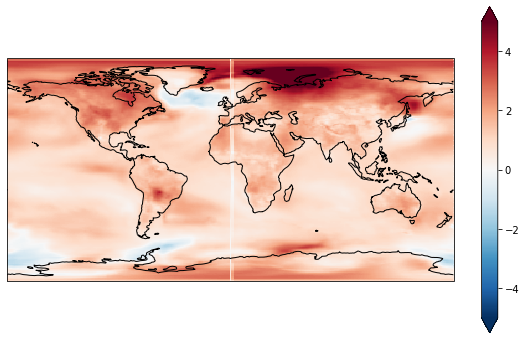

In [57]:
fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize = [10,6])
increase_out.sel(year = 50).plot(ax = ax, transform = ccrs.PlateCarree(), vmin = -5, vmax = 5, cmap = 'RdBu_r', extend = 'both')
ax.coastlines()
plt.title('')
plt.savefig('figures/conv_50_yrs_mean.pdf', bbox_inches = 'tight', dpi = 350)

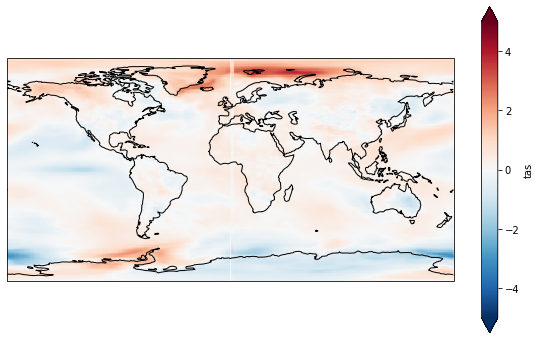

In [56]:
fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize = [10,6])
(G_mean_ds.isel(year = 50)*100).plot(ax = ax, transform = ccrs.PlateCarree(), vmin = -5, vmax = 5, cmap = 'RdBu_r', extend = 'both')
ax.coastlines()
#ax.set_title('30 years')
plt.title('')
plt.savefig('figures/G_50_yrs_mean.pdf', bbox_inches = 'tight', dpi = 350)

In [ ]:
fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize = [10,6])
increase_out.sel(year = 30).plot(ax = ax, transform = ccrs.PlateCarree(), vmin = -5, vmax = 5, cmap = 'RdBu_r')
ax.coastlines()
#ax.set_title('30 years')

Text(0.5, 1.0, '50 years')

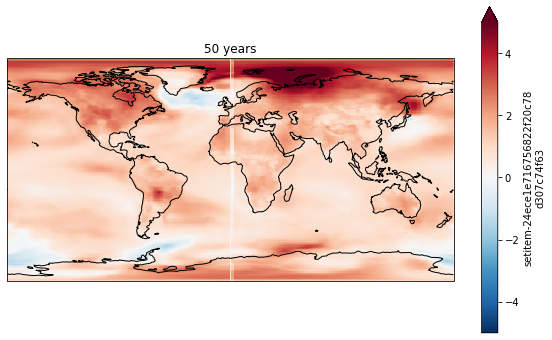

In [42]:
fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize = [10,6])
increase_out.sel(s = 50).plot(ax = ax, transform = ccrs.PlateCarree(), vmin = -5, vmax = 5, cmap = 'RdBu_r')
ax.coastlines()
ax.set_title('50 years')

Text(0.5, 1.0, '50 years')

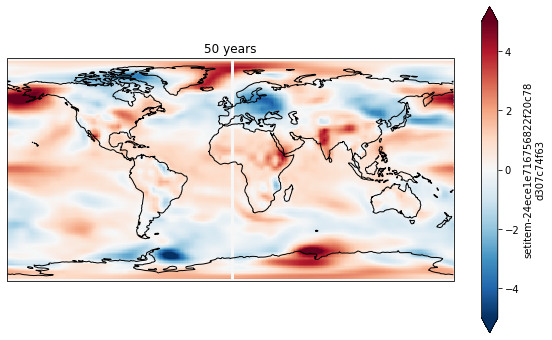

In [43]:
fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize = [10,6])
increase_out.sel(s = 200).plot(ax = ax, transform = ccrs.PlateCarree(), vmin = -5, vmax = 5, cmap = 'RdBu_r')
ax.coastlines()
ax.set_title('50 years')

Text(0.5, 1.0, '50 years')

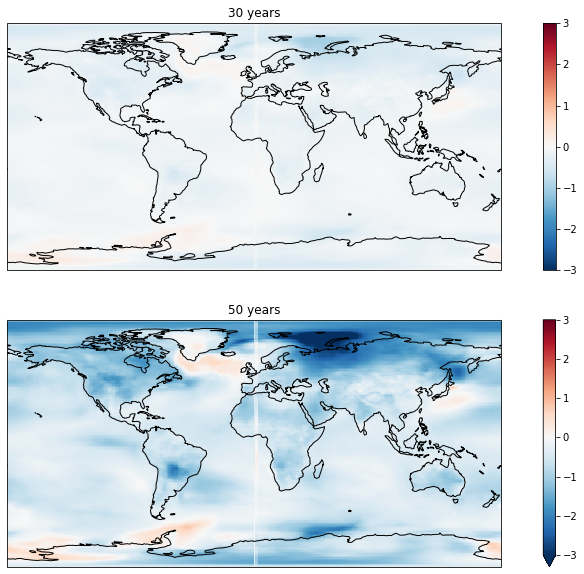

In [155]:
fig, [ax1, ax2] = plt.subplots(2,1, subplot_kw={'projection':ccrs.PlateCarree()}, figsize = [15,10])
(plateau_out.isel(s = 30)-increase_out.isel(s = 30)).plot(ax = ax1, transform = ccrs.PlateCarree(), vmin = -3, vmax = 3, cmap = 'RdBu_r')
ax1.coastlines()
ax1.set_title('30 years')
(plateau_out.isel(s = 50)-increase_out.isel(s = 50)).plot(ax = ax2, transform = ccrs.PlateCarree(), vmin = -3, vmax = 3, cmap = 'RdBu_r')
ax2.coastlines()
ax2.set_title('50 years')

#plt.title('30 years in, split from increase to decrease')